In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

IMAGE_SIZE = (50, 50)

colors = ['blue', 'red', 'green']
color_map = {
    'blue': '#0000FF',
    'red': '#FF0000',
    'green': '#00FF00'
}
shapes = ['square', 'circle', 'triangle']

def get_dimensions():
    width, height = IMAGE_SIZE
    size = np.random.randint(10, width / 2)
    left = np.random.randint(0, width - size)
    top = np.random.randint(0, height - size)
    
    return left, top, size

def draw_shape(img, color, shape):
    idraw = ImageDraw.Draw(img)
    left, top, size = get_dimensions()
    if shape is 'square':
        idraw.rectangle((left, top, left+size, top+size), fill=color_map[color])
    elif shape is 'circle':
        idraw.ellipse((left, top, left+size, top+size), fill=color_map[color])
    elif shape is 'triangle':
        idraw.polygon([(left, top+size), (left+size, top+size), (left+size/2, top)], fill=color_map[color])
    
def generate_shape_color_binary_questions(color, shape):
    questions = []
    for color2 in colors:
        for shape2 in shapes:
            questions.append((color, shape, 'Does the image contain a {} {}?'.format(color2, shape2), 'Yes' if color == color2 and shape == shape2 else 'No'))
            questions.append((color, shape, 'Is there a {} {}?'.format(color2, shape2), 'Yes' if color == color2 and shape == shape2 else 'No'))
    
    return questions

def generate_shape_binary_questions(color, shape):
    questions = []
    for shape2 in shapes:
        questions.append((color, shape, 'Does the image contain a {}?'.format(shape2), 'Yes' if shape == shape2 else 'No'))
        questions.append((color, shape, 'Is there a {}?'.format(shape2), 'Yes' if shape == shape2 else 'No'))
    
    return questions

def generate_color_binary_questions(color, shape):
    questions = []
    for color2 in colors:
        questions.append((color, shape, 'Does the image contain a {} shape?'.format(color2), 'Yes' if color == color2 else 'No'))
        questions.append((color, shape, 'Is there a {} shape?'.format(color2), 'Yes' if color == color2 else 'No'))
    
    return questions

def generate_shape_question(color, shape):
    return [
        (color, shape, 'Which color is in the image?', color)
    ]

def generate_color_question(color, shape):
    return [
        (color, shape, 'Which shape is in the image?', shape)
    ]
    
def generate_question_answer_pairs(color, shape):
    questions = []
    questions.extend(generate_shape_color_binary_questions(color, shape))
    questions.extend(generate_shape_binary_questions(color, shape))
    questions.extend(generate_color_binary_questions(color, shape))
    questions.extend(generate_shape_question(color, shape))
    questions.extend(generate_color_question(color, shape))
    
    return questions

questions = []
for shape in shapes:
    for color in colors:
        questions.extend(generate_question_answer_pairs(color, shape))
        for index in range(10):
            if not os.path.isdir('./data/{}/{}'.format(color, shape)):
                os.makedirs('./data/{}/{}'.format(color, shape))
            img = Image.new('RGB', IMAGE_SIZE, 'white') 
            draw_shape(img, color, shape)
            #img = img.rotate(45)
            img.save('./data/{}/{}/{}_{}_{}'.format(color, shape, color, shape, index) + ".jpg", "JPEG")
            #plt.imshow(img)
            #plt.show()

f = open('./data/questions.txt', 'w+')
for color, shape, question, answer in questions:
     f.write('{},{},{},{}\n'.format(color, shape, question, answer))
f.close()

In [2]:
import glob
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def normalize_image(image):
    return image / 255

def load_images(color, shape):
    return [normalize_image(np.array(Image.open(path).convert('L'))) for path in glob.glob('./data/{}/{}/*.jpg'.format(color, shape))]

def load_questions(color, shape):
    data = pd.read_csv('./data/questions.txt', names=['color', 'shape', 'question', 'answer'])

    return data[(data['color'] == color) & (data['shape'] == shape)][['question', 'answer']].values
    
def load_images_and_question(color, shape):
    images = load_images(color, shape)
    questions = load_questions(color, shape)
    
    return [(image, question, answer) for image in images for (question, answer) in questions]


#for (image, question, answer) in load_images_and_question('green', 'square'):
#    plt.imshow(image)
#    plt.show()
#    print(image.shape, question, answer)

print(np.min(load_images_and_question('red', 'square')[0][0]))
print(np.min(load_images_and_question('green', 'square')[0][0]))
print(np.min(load_images_and_question('blue', 'square')[0][0]))

0.21568627450980393
0.5450980392156862
0.06274509803921569


In [3]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def load_all_data():
    images_and_questions = []
    for color in colors:
        for shape in shapes:
            images_and_questions += load_images_and_question(color, shape)
            
    return pd.DataFrame(np.array(images_and_questions), columns=['image', 'question', 'answer'])

def clean_sentence(sentence):
    lowercase_sentence = sentence.lower()
    return re.sub('[?,.\-!:;]', '', lowercase_sentence)
    
data = load_all_data()

data['cleaned_question'] = data['question'].apply(lambda s : clean_sentence(s))
data['cleaned_answer'] = data['answer'].apply(lambda s : clean_sentence(s))

question_vectorizer = CountVectorizer(analyzer='word', lowercase=True, binary=True)
data['transformed_question'] = [vector.toarray()[0] for vector in question_vectorizer.fit_transform(data['cleaned_question'].values)]
answer_vectorizer = CountVectorizer(analyzer='word', lowercase=True, binary=True)
data['transformed_answer'] = [vector.toarray()[0] for vector in answer_vectorizer.fit_transform(data['cleaned_answer'].values)]

print(data.head())

                                               image  \
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
4  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                  question answer  \
0    Does the image contain a blue square?    Yes   
1                  Is there a blue square?    Yes   
2    Does the image contain a blue circle?     No   
3                  Is there a blue circle?     No   
4  Does the image contain a blue triangle?     No   

                         cleaned_question cleaned_answer  \
0    does the image contain a blue square            yes   
1                  is there a blue square            yes   
2    does the image contain a blue circle             no   
3                  is there a blue circle             no   
4  does the image contain a blue triangle   

Number of words: 16, vocabulary: {'does': 4, 'the': 12, 'image': 6, 'contain': 3, 'blue': 0, 'square': 11, 'is': 8, 'there': 13, 'circle': 1, 'triangle': 14, 'red': 9, 'green': 5, 'shape': 10, 'which': 15, 'color': 2, 'in': 7}
[1530 1530 1530 1350 1350 1350  720  720  720  720  720  720  630  180
  180   90]


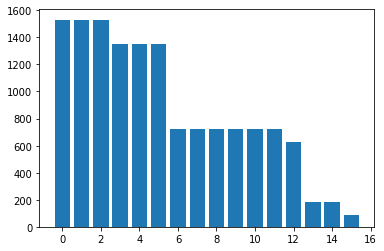

[[1530, 'the'], [1530, 'image'], [1530, 'is'], [1350, 'does'], [1350, 'contain'], [1350, 'there'], [720, 'blue'], [720, 'square'], [720, 'circle'], [720, 'triangle'], [720, 'red'], [720, 'green'], [630, 'shape'], [180, 'which'], [180, 'in'], [90, 'color']]


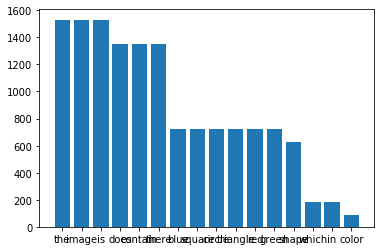

In [4]:
import matplotlib.pyplot as plt

concatenated_questions = ' '.join(data['cleaned_question'])
question_vectorizer_2 = CountVectorizer(analyzer='word', lowercase=True)
vector = question_vectorizer_2.fit_transform([concatenated_questions]).toarray()[0]
sorted_vector = np.sort(vector)[::-1]
print('Number of words: {}, vocabulary: {}'.format(len(question_vectorizer_2.vocabulary_), question_vectorizer_2.vocabulary_))
print(sorted_vector)

plt.bar(range(len(sorted_vector)), sorted_vector)
plt.show()

vector_dictionary = [[vector[index], word] for (word, index) in question_vectorizer_2.vocabulary_.items()]
vector_dictionary.sort(key=lambda x : x[0], reverse=True)
print(vector_dictionary)
counts = [count for [count, _] in vector_dictionary]
words = [word for [_, word] in vector_dictionary]
plt.bar(words, counts)
plt.show()

In [5]:
print('Number of words: {}, vocabulary: {}'.format(len(answer_vectorizer.vocabulary_), answer_vectorizer.vocabulary_))

Number of words: 8, vocabulary: {'yes': 7, 'no': 3, 'blue': 0, 'square': 5, 'circle': 1, 'triangle': 6, 'red': 4, 'green': 2}


In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

def adam_optimizer():
    return Adam(lr = 0.001, beta_1 = 0.5)

def get_image_cnn():
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), 
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    return model

def get_question_nn():
    model = Sequential()
    model.add(Dense(12, input_shape=(16,), activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation='relu'))
    return model

def get_model():
    image_model = get_image_cnn()
    question_model = get_question_nn()
    input_image = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    input_question = Input(shape=(16,))
    
    image_result = image_model(input_image)
    question_result = question_model(input_question)
    result = concatenate([image_result, question_result])
    result = Dense(12, activation='relu')(result)
    result = Dropout(0.1)(result)
    result = Dense(8, activation='softmax')(result)
    model = Model(inputs=[input_image, input_question], outputs=result)
    model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return model

get_model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           37232       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 8)            308         input_2[0][0]                    
______________________________________________________________________________________________

(2592, 50, 50, 1) (2592, 16) (2592, 8)
Train on 2592 samples
Epoch 1/50
2592/2592 [==============================] - 9s 4ms/sample - loss: 0.9000 - accuracy: 0.7488
Epoch 2/50
2592/2592 [==============================] - 8s 3ms/sample - loss: 0.6127 - accuracy: 0.7674
Epoch 3/50
2592/2592 [==============================] - 8s 3ms/sample - loss: 0.5815 - accuracy: 0.7658
Epoch 4/50
2592/2592 [==============================] - 9s 3ms/sample - loss: 0.5634 - accuracy: 0.7681
Epoch 5/50
2592/2592 [==============================] - 10s 4ms/sample - loss: 0.5654 - accuracy: 0.7666s - loss: 0.566
Epoch 6/50
2592/2592 [==============================] - 13s 5ms/sample - loss: 0.5601 - accuracy: 0.7681
Epoch 7/50
2592/2592 [==============================] - 10s 4ms/sample - loss: 0.5570 - accuracy: 0.7677
Epoch 8/50
2592/2592 [==============================] - 8s 3ms/sample - loss: 0.5479 - accuracy: 0.7720
Epoch 9/50
2592/2592 [==============================] - 9s 3ms/sample - loss: 0.5378 - ac

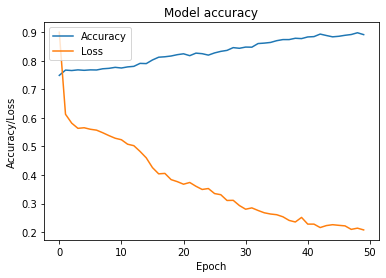

In [7]:
from sklearn.model_selection import train_test_split

# data_filtered = data[(data['answer'] == 'circle') | (data['answer'] == 'square') | (data['answer'] == 'triangle')]
# data_filtered = data[(data['answer'] == 'red') | (data['answer'] == 'green') | (data['answer'] == 'blue')]
# data_filtered = data[(data['answer'] == 'red') | (data['answer'] == 'green') | (data['answer'] == 'blue') | (data['answer'] == 'circle') | (data['answer'] == 'square') | (data['answer'] == 'triangle')]
data_filtered = data

images, questions, answers = data_filtered['image'].values, data_filtered['transformed_question'].values, data_filtered['transformed_answer'].values
images = np.array([image.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1) for image in images])
questions = np.array([question.reshape(16) for question in questions])
answers = np.array([answer.reshape(8) for answer in answers])

train_images, test_images, train_questions, test_questions, train_answers, test_answers = train_test_split(images, questions, answers, test_size=0.1, random_state=42)

print(train_images.shape, train_questions.shape, train_answers.shape)

model = get_model()

history = model.fit([train_images, train_questions], train_answers, epochs=50, batch_size=4)

model.evaluate([test_images, test_questions], test_answers, verbose=2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

Confusion matrix


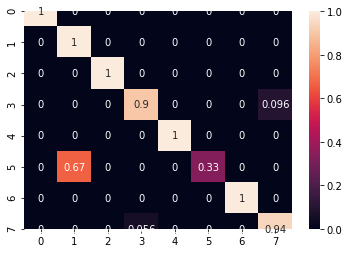

Precision: 0.9199689089881289
Recall: 0.8977272727272727
f1_score: 0.8806223072351804


In [8]:
import seaborn as sn
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = np.argmax(model.predict([test_images, test_questions]), axis=1)
y_test = np.argmax(test_answers, axis=1)

print('Confusion matrix')
matrix = tf.math.confusion_matrix(y_test, y_pred).numpy()
row_sums = np.sum(matrix, axis=1)
matrix = np.around(matrix / row_sums[:,None], decimals=3)
sn.heatmap(matrix, annot=True)
plt.show()
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('f1_score:', f1_score(y_test, y_pred, average='macro'))

Image:


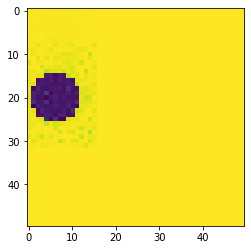

Encoded question: [0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0]
Correct answer: 3
Predicted answer: 3


In [9]:
print('Image:')
plt.imshow(test_images[0].reshape(IMAGE_SIZE))
plt.show()
print('Encoded question:', test_questions[0])
print('Correct answer:', np.argmax(test_answers[0]))
print('Predicted answer:', np.argmax(model.predict([[test_images[0]], [test_questions[0]]]), axis=1)[0])

Test label distribution


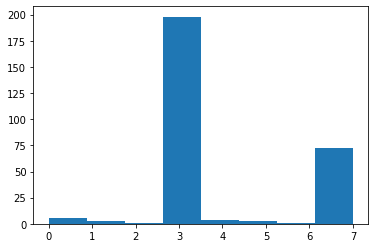

In [10]:
print('Test label distribution')
plt.hist(y_test, bins=8)
plt.show()